In [6]:
import sys
sys.path.append("..")

from adapt_utils import replace_symbols

from tree_parser import *

import networkx as nx

import matplotlib
import matplotlib.pyplot as plt

from networkx.drawing.nx_pydot import graphviz_layout

import copy

import time

from my_utils import print_proof_props_graph, get_proof_steps, print_ident_proof, print_proof_linear_steps
from my_utils import get_proof_steps_graph, print_proof_steps_graph

import pickle

In [2]:
%%time

text = file_contents("../set.mm")
database = meta_math_database(text,n=3500)

included 5555695 tokens from ../set.mm
proposition: 3500CPU times: user 9.62 s, sys: 309 ms, total: 9.93 s
Wall time: 10.1 s


In [42]:
context_values = dict()

for prop in database.propositions_list:
    for k, v in prop.f.items():
        if k in context_values:
            if v.statement != context_values[k]:
                print(k, v.statement, context_values[k])
                break
        else:
            context_values[k] = v.statement

def eval_tree(tree):
    if tree.value in context_values: 
        return context_values[tree.value]
    
    prop = database.propositions[tree.value]
    assert len(tree.leaves)==len(prop.hyps)
    
    replacement_dict = {prop.hyps[i].variable: eval_tree(tree.leaves[i]) for i in range(len(prop.hyps)) if prop.hyps[i].type == "f"} #find the replacement rules for the variables
    #print 'replacement_dict', replacement_dict, 'applied to', prop.statement
    return string_replace(prop.statement[1:],replacement_dict)

def tree2str(tree):
    evaluated_tree = eval_tree(tree)
    return replace_symbols(" ".join(evaluated_tree))

In [208]:
def get_step_replace_dict(step):
    
    repdict = {}
    
    #In case we are dealing with already hypotehsis nodes, there no hypothesis to work with
    #since there is no hypotehsis of a hypothesis, we need to wrap the hyps within get_prop_hyps
    
    e_hyps = [h for h in get_prop_hyps(step.prop) if h.type == 'e']
    assert len(e_hyps) == len(step._prior_entails), print(len(e_hyps), len(step._prior_entails))

    #Populate with hypothesis
    for raw_hyp, rep_hyp in zip(e_hyps, step._prior_entails):

        raw_tree = raw_hyp.tree
        rep_tree = rep_hyp.tree

        for pos in raw_tree.breadth_first_position_list():
            raw_subtree = raw_tree.tree_at_position(pos)
            rep_subtree = rep_tree.tree_at_position(pos)
            if raw_subtree.value != rep_subtree.value:
                repdict[raw_subtree.value] = rep_subtree

    if len(e_hyps) == 0 or True:
        #Populate with conclusion (this is necessary when there is no hypothesis)
        raw_tree = step.prop.tree
        rep_tree = step.tree

        for pos in raw_tree.breadth_first_position_list():
            raw_subtree = raw_tree.tree_at_position(pos)
            rep_subtree = rep_tree.tree_at_position(pos)
            if raw_subtree.value != rep_subtree.value:
                if raw_subtree.value in repdict and rep_subtree != repdict[raw_subtree.value]:
                    print(rep_subtree, repdict[raw_subtree.value])
                    raise Exception("Different trees within same node!")
                else:
                    repdict[raw_subtree.value] = rep_subtree
        
    return repdict

In [209]:
def get_prop_hyps(prop):
    #We should use this function instead of direct checking for hypothesis
    #because if the prop is already a hypothesis, this property will not exist
    #which will raise an exception. This encapsulates and resolves this
    return prop.hyps if hasattr(prop, "hyps") else []

In [233]:
def expand_proof_step(root_step):
    
    expanded_steps = []
    
    if not hasattr(root_step, "replace_dict_list"):
        root_step.replace_dict_list = [get_step_replace_dict(root_step)]
        
    step2exp = dict() #Store references from steps to expanded steps to populate 
    
    for child_step in root_step.prop.entails_proof_steps:
        #Take the original prop tree
        exp_tree = child_step.prop.tree.copy()
        
        #Take the step transformation that was used to the raw step to the replace step
        replace_dict_list = [get_step_replace_dict(child_step)]
            
        #Get the root step replace dicts so we can iterativelly expand the steps
        replace_dict_list.extend(root_step.replace_dict_list)
        
        for rep_dict in replace_dict_list:
            exp_tree = exp_tree.replace(rep_dict)
        
        prior_statements = child_step.prior_statements if hasattr(child_step, "prior_statements") else []
        
        exp_step = proof_step(exp_tree, root_step.context, child_step.prop, prior_statements)
        exp_step.replace_dict_list = replace_dict_list
        
        expanded_steps.append(exp_step)
        
        step2exp[child_step] = exp_step
        
    #Populate _prior_entails
    for child_step in root_step.prop.entails_proof_steps:
        step2exp[child_step]._prior_entails = [step2exp.get(cc, cc) for cc in child_step._prior_entails]
    
        
    return expanded_steps

In [234]:
class Step:
    def __init__(self, name):
        self.name = name

def get_proof_graph_pn(pn, node_label="label"):
    G = nx.DiGraph()
    return _get_proof_graph_pn_recursive(pn, G, node_label), G

def _get_proof_graph_pn_recursive(pn, G, node_label="label"):
    if node_label == "label+statement":
        pn_gstep = Step(f"[{pn.label}] {pn.statement}")
    else:
        pn_gstep = Step(pn.label)
        
    for pni in pn.inputs:
        pni_gstep = _get_proof_graph_pn_recursive(pni, G, node_label)
        G.add_edge(pn_gstep, pni_gstep)
    return pn_gstep

def print_proof_props_graph_pn(pn, node_label="label"):
    
    root, G = get_proof_graph_pn(pn, node_label)

    graph_nodes = list(nx.dfs_preorder_nodes(G, root, 9))

    graph_nodes_labels = {n:n.name for n in graph_nodes}

    plt.figure(figsize=(10, 5))
    pos = graphviz_layout(G.subgraph(graph_nodes), prog="dot")#twopi
    nx.draw(G.subgraph(graph_nodes), pos, labels=graph_nodes_labels, node_color="w", node_size=2000)
    plt.show()

In [315]:
def expand_proof_step_ps(root_step):
    
    root_step = root_step._step
    
    expanded_steps = []
    
    if not hasattr(root_step, "replace_dict_list"):
        root_step.replace_dict_list = [get_step_replace_dict(root_step)]
        
    step2exp = dict() #Store references from steps to expanded steps to populate
    
    #Get all steps (This is necessary because entails_proof_step does not return hypothesis)
    all_steps = []
    for s in root_step.prop.entails_proof_steps:
        if s not in all_steps:
            all_steps.append(s)
        for s_child in s._prior_entails:
            if s_child not in all_steps:
                all_steps.append(s_child)
    
    
    for child_step in all_steps:
        #Take the original prop tree
        exp_tree = child_step.prop.tree.copy()
        
        #Take the step transformation that was used to the raw step to the replace step
        replace_dict_list = [get_step_replace_dict(child_step)]
            
        #Get the root step replace dicts so we can iterativelly expand the steps
        replace_dict_list.extend(root_step.replace_dict_list)
        
        for rep_dict in replace_dict_list:
            exp_tree = exp_tree.replace(rep_dict)
        
        prior_statements = child_step.prior_statements if hasattr(child_step, "prior_statements") else []
        
        exp_step = proof_step(exp_tree, root_step.context, child_step.prop, prior_statements)
        exp_step.replace_dict_list = replace_dict_list
        
        expanded_steps.append(exp_step)
        
        step2exp[child_step] = exp_step
        
    #Populate _prior_entails
    for child_step in all_steps:
        step2exp[child_step]._prior_entails = [step2exp.get(cc, cc) for cc in child_step._prior_entails]
    
    
    #Create PStep wrappers and populate inputs and outputs
    expanded_steps_dict = {}
    for es in expanded_steps:
        expanded_steps_dict[es] = PStep(es)
    
    for es, es_ps in expanded_steps_dict.items():
        for child_es in es._prior_entails:
            if child_es not in expanded_steps_dict:
                continue
            child_es_ps = expanded_steps_dict[child_es]
            es_ps.inputs.append(child_es_ps)
            child_es_ps.output = es_ps
        
    return list(expanded_steps_dict.values())[0].get_root_step()

In [324]:
class PStep:
    def __init__(self, step):
        self._step = step
        self.is_hyp = step.prop.type == 'e'
        
        self.output = None
        self.inputs = []
    
    @property 
    def context(self):
        return self._step.context
    
    @property 
    def prop(self):
        return self._step.prop
    
    @property
    def label(self):
        return self._step.prop.label
    
    @property 
    def _prior_entails(self):
        return self._step._prior_entails
    
    @property 
    def tree(self):
        return self._step.tree
        
    def get_root_step(self):
        if self.output == None:
            return self
        return self.output.get_root_step() 
    
    def get_hyps(self, hyps=None):
        if hyps == None:
            hyps = []
            
        if self.is_hyp:
            assert len(self.inputs) == 0 #Sanity check
            hyps.append(self)
        else:
            for c in self.inputs:
                c.get_hyps(hyps)
        return hyps
    
    def expand(self):
        exp_self = expand_proof_step_ps(self)
        exp_self_root_step = replace_expanded_step(self, exp_self)
        return exp_self_root_step
        
    
    @property
    def statement(self):
        return tree2str(self.tree)
    
    def __repr__(self):
        obj_name = "PStep" if not self.is_hyp else "PHyp"
        return f"<P{obj_name}:{self._step.prop.label} ⊢ {self.statement}>"
    
    def print_graph(self):
        print_proof_props_graph_pn(self)
    
    def print_linear(self, ident=0):
        print(" | " * ident, self)
        for cs in self.inputs:
            print_proof_steps_pn(cs, ident+1)
    
def construct_proof(prop):
    root_step = prop.entails_proof_steps[-1]
    return _construct_proof_recursive(root_step)
    
def _construct_proof_recursive(s):
    ps = PStep(s)
    for child_s in s._prior_entails:
        child_ps = _construct_proof_recursive(child_s)
        ps.inputs.append(child_ps)
    return ps

In [325]:
def replace_expanded_step(step, expanded_step):
    # Replace root node
    if step.output != None:
        expanded_step.output = step.output
        step_output_index = step.output.inputs.index(step)
        step.output.inputs[step_output_index] = expanded_step
        
    # Replace hyps
    ## Get hyps out nodes (this is necessary because hyp nodes must be replaced and not connected)
    #expanded_step_hyps = [h.output for h in expanded_step.get_hyps()]
    expanded_step_hyps = expanded_step.get_hyps()
    assert len(step.inputs) == len(expanded_step_hyps), f"{len(step.inputs)} {step.inputs} {len(expanded_step_hyps)} {expanded_step_hyps}"
    for step_input, exp_hyp in zip(step.inputs, expanded_step_hyps):
        step_input.output = exp_hyp.output #(this is necessary because hyp nodes must be replaced and not connected)
        exp_hyp_index = exp_hyp.output.inputs.index(exp_hyp)
        exp_hyp.output.inputs[exp_hyp_index] = step_input
        
    #Return new proof
    #Maybe it is a good idea to perform a deepcopy of every step
    return expanded_step.get_root_step()     

In [347]:
prop = database.propositions["dfss2"]
prop_proof = construct_proof(prop)

In [348]:
prop_proof.print_linear()

 <PPStep:bitr4i ⊢ ( A ⊆ B ↔ ∀ x ( x ∈ A → x ∈ B ) )>
 |  <PPStep:3bitri ⊢ ( A ⊆ B ↔ ∀ x ( x ∈ A ↔ ( x ∈ A ∧ x ∈ B ) ) )>
 |  |  <PPStep:dfss ⊢ ( A ⊆ B ↔ A = ( A ∩ B ) )>
 |  |  <PPStep:eqeq2i ⊢ ( A = ( A ∩ B ) ↔ A = { x | ( x ∈ A ∧ x ∈ B ) } )>
 |  |  |  <PPStep:df-in ⊢ ( A ∩ B ) = { x | ( x ∈ A ∧ x ∈ B ) }>
 |  |  <PPStep:abeq2 ⊢ ( A = { x | ( x ∈ A ∧ x ∈ B ) } ↔ ∀ x ( x ∈ A ↔ ( x ∈ A ∧ x ∈ B ) ) )>
 |  <PPStep:albii ⊢ ( ∀ x ( x ∈ A → x ∈ B ) ↔ ∀ x ( x ∈ A ↔ ( x ∈ A ∧ x ∈ B ) ) )>
 |  |  <PPStep:pm4.71 ⊢ ( ( x ∈ A → x ∈ B ) ↔ ( x ∈ A ↔ ( x ∈ A ∧ x ∈ B ) ) )>


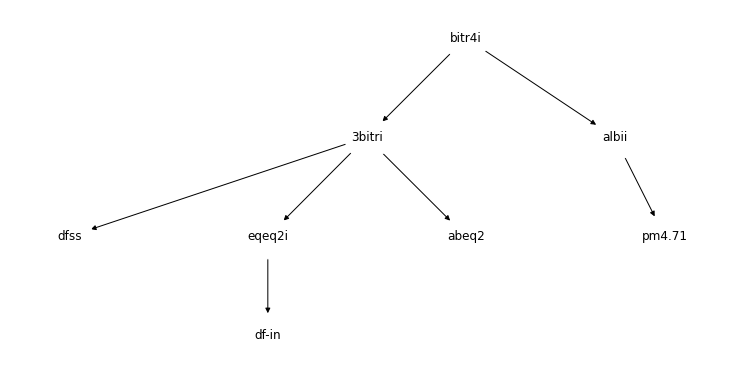

In [349]:
prop_proof.print_graph()

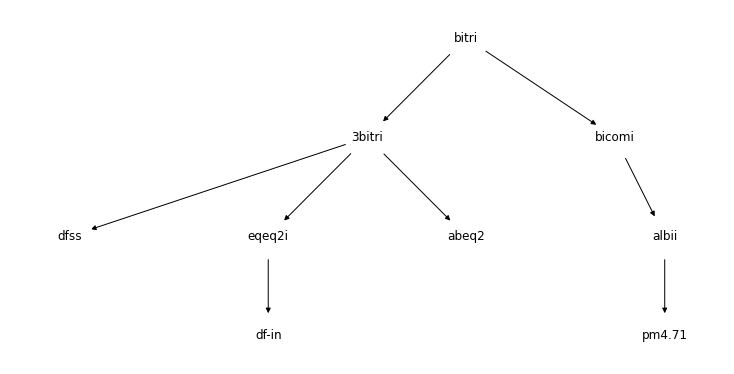

In [350]:
prop_proof = prop_proof.expand()
prop_proof.print_graph()

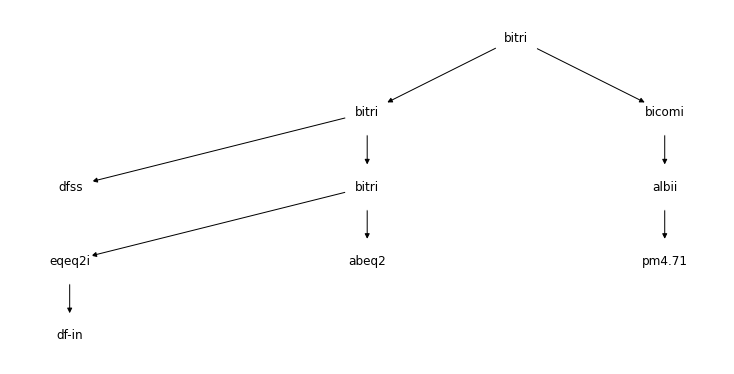

In [351]:
prop_proof = prop_proof.inputs[0].expand()
prop_proof.print_graph()

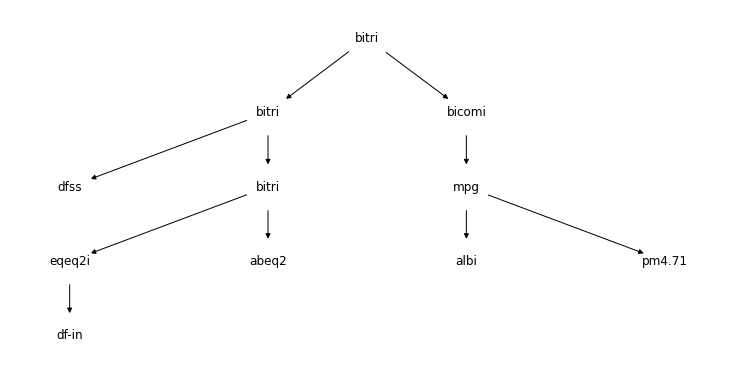

In [356]:
prop_proof.inputs[1].inputs[0].expand()
prop_proof.print_graph()

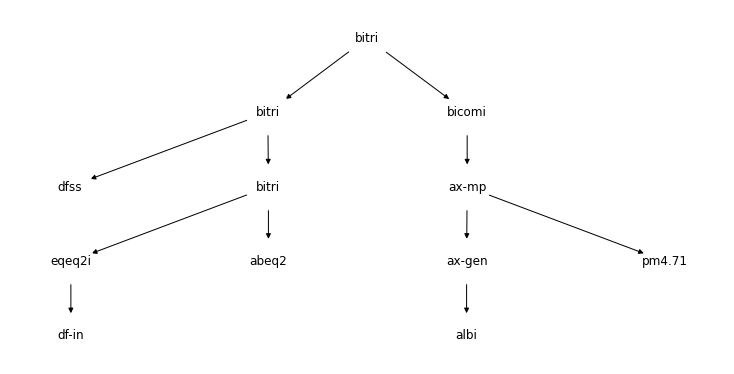

In [359]:
prop_proof.inputs[1].inputs[0].expand()
prop_proof.print_graph()

In [366]:
prop_proof.inputs[1].inputs[0].inputs[0].inputs[0].expand()

<PPStep:bitri ⊢ ( A ⊆ B ↔ ∀ x ( x ∈ A → x ∈ B ) )>

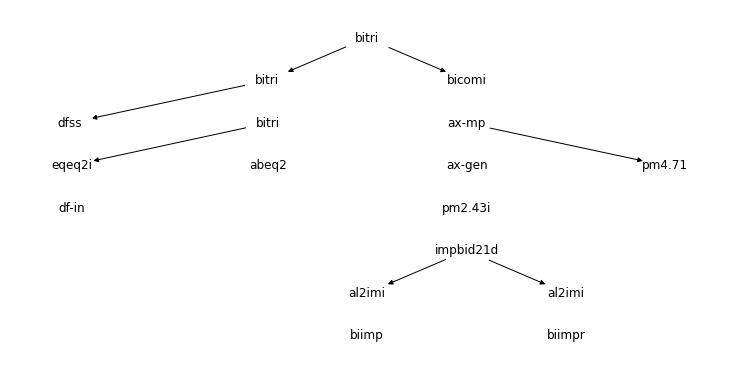

In [371]:
prop_proof.print_graph()

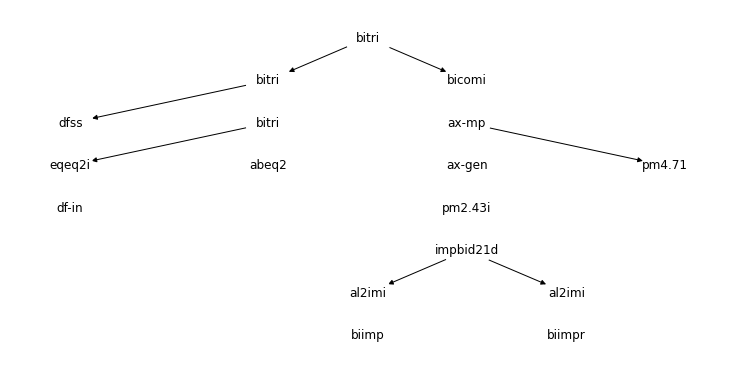

In [370]:
prop_proof.inputs[1].inputs[0].inputs[0].inputs[0].expand()
prop_proof.print_graph()

In [368]:
prop_proof.print_linear()

 <PPStep:bitri ⊢ ( A ⊆ B ↔ ∀ x ( x ∈ A → x ∈ B ) )>
 |  <PPStep:bitri ⊢ ( A ⊆ B ↔ ∀ x ( x ∈ A ↔ ( x ∈ A ∧ x ∈ B ) ) )>
 |  |  <PPStep:dfss ⊢ ( A ⊆ B ↔ A = ( A ∩ B ) )>
 |  |  <PPStep:bitri ⊢ ( A = ( A ∩ B ) ↔ ∀ x ( x ∈ A ↔ ( x ∈ A ∧ x ∈ B ) ) )>
 |  |  |  <PPStep:eqeq2i ⊢ ( A = ( A ∩ B ) ↔ A = { x | ( x ∈ A ∧ x ∈ B ) } )>
 |  |  |  |  <PPStep:df-in ⊢ ( A ∩ B ) = { x | ( x ∈ A ∧ x ∈ B ) }>
 |  |  |  <PPStep:abeq2 ⊢ ( A = { x | ( x ∈ A ∧ x ∈ B ) } ↔ ∀ x ( x ∈ A ↔ ( x ∈ A ∧ x ∈ B ) ) )>
 |  <PPStep:bicomi ⊢ ( ∀ x ( x ∈ A ↔ ( x ∈ A ∧ x ∈ B ) ) ↔ ∀ x ( x ∈ A → x ∈ B ) )>
 |  |  <PPStep:ax-mp ⊢ ( ∀ x ( x ∈ A → x ∈ B ) ↔ ∀ x ( x ∈ A ↔ ( x ∈ A ∧ x ∈ B ) ) )>
 |  |  |  <PPStep:ax-gen ⊢ ∀ x ( ( x ∈ A → x ∈ B ) ↔ ( x ∈ A ↔ ( x ∈ A ∧ x ∈ B ) ) )>
 |  |  |  |  <PPStep:impbid ⊢ ( ∀ x ( ( x ∈ A → x ∈ B ) ↔ ( x ∈ A ↔ ( x ∈ A ∧ x ∈ B ) ) ) → ( ∀ x ( x ∈ A → x ∈ B ) ↔ ∀ x ( x ∈ A ↔ ( x ∈ A ∧ x ∈ B ) ) ) )>
 |  |  |  |  |  <PPStep:al2imi ⊢ ( ∀ x ( ( x ∈ A → x ∈ B ) ↔ ( x ∈ A ↔ ( x ∈ A ∧ x ∈ B ) ) ) → ( ∀

In [304]:
root_step = prop_proof
print(root_step)
print()

exp_proof = expand_proof_step_ps(root_step)
exp_proof.print_linear()

<PPStep:bitr4i ⊢ ( A ⊆ B ↔ ∀ x ( x ∈ A → x ∈ B ) )>

 <PPStep:bitri ⊢ ( A ⊆ B ↔ ∀ x ( x ∈ A → x ∈ B ) )>
 |  <PPHyp:bitr4i.1 ⊢ ( A ⊆ B ↔ ∀ x ( x ∈ A ↔ ( x ∈ A ∧ x ∈ B ) ) )>
 |  <PPStep:bicomi ⊢ ( ∀ x ( x ∈ A ↔ ( x ∈ A ∧ x ∈ B ) ) ↔ ∀ x ( x ∈ A → x ∈ B ) )>
 |  |  <PPHyp:bitr4i.2 ⊢ ( ∀ x ( x ∈ A → x ∈ B ) ↔ ∀ x ( x ∈ A ↔ ( x ∈ A ∧ x ∈ B ) ) )>


In [311]:
prop = database.propositions["dfss2"]
prop_proof = construct_proof(prop)

root_step = prop_proof
exp_proof = expand_proof_step_ps(root_step)

prop_proof.print_linear()
print()
exp_proof.print_linear()

 <PPStep:bitr4i ⊢ ( A ⊆ B ↔ ∀ x ( x ∈ A → x ∈ B ) )>
 |  <PPStep:3bitri ⊢ ( A ⊆ B ↔ ∀ x ( x ∈ A ↔ ( x ∈ A ∧ x ∈ B ) ) )>
 |  |  <PPStep:dfss ⊢ ( A ⊆ B ↔ A = ( A ∩ B ) )>
 |  |  <PPStep:eqeq2i ⊢ ( A = ( A ∩ B ) ↔ A = { x | ( x ∈ A ∧ x ∈ B ) } )>
 |  |  |  <PPStep:df-in ⊢ ( A ∩ B ) = { x | ( x ∈ A ∧ x ∈ B ) }>
 |  |  <PPStep:abeq2 ⊢ ( A = { x | ( x ∈ A ∧ x ∈ B ) } ↔ ∀ x ( x ∈ A ↔ ( x ∈ A ∧ x ∈ B ) ) )>
 |  <PPStep:albii ⊢ ( ∀ x ( x ∈ A → x ∈ B ) ↔ ∀ x ( x ∈ A ↔ ( x ∈ A ∧ x ∈ B ) ) )>
 |  |  <PPStep:pm4.71 ⊢ ( ( x ∈ A → x ∈ B ) ↔ ( x ∈ A ↔ ( x ∈ A ∧ x ∈ B ) ) )>

 <PPStep:bitri ⊢ ( A ⊆ B ↔ ∀ x ( x ∈ A → x ∈ B ) )>
 |  <PPHyp:bitr4i.1 ⊢ ( A ⊆ B ↔ ∀ x ( x ∈ A ↔ ( x ∈ A ∧ x ∈ B ) ) )>
 |  <PPStep:bicomi ⊢ ( ∀ x ( x ∈ A ↔ ( x ∈ A ∧ x ∈ B ) ) ↔ ∀ x ( x ∈ A → x ∈ B ) )>
 |  |  <PPHyp:bitr4i.2 ⊢ ( ∀ x ( x ∈ A → x ∈ B ) ↔ ∀ x ( x ∈ A ↔ ( x ∈ A ∧ x ∈ B ) ) )>


In [312]:
rep_exp_proof = replace_expanded_step(root_step, exp_proof)

In [313]:
rep_exp_proof.print_linear()

 <PPStep:bitri ⊢ ( A ⊆ B ↔ ∀ x ( x ∈ A → x ∈ B ) )>
 |  <PPStep:3bitri ⊢ ( A ⊆ B ↔ ∀ x ( x ∈ A ↔ ( x ∈ A ∧ x ∈ B ) ) )>
 |  |  <PPStep:dfss ⊢ ( A ⊆ B ↔ A = ( A ∩ B ) )>
 |  |  <PPStep:eqeq2i ⊢ ( A = ( A ∩ B ) ↔ A = { x | ( x ∈ A ∧ x ∈ B ) } )>
 |  |  |  <PPStep:df-in ⊢ ( A ∩ B ) = { x | ( x ∈ A ∧ x ∈ B ) }>
 |  |  <PPStep:abeq2 ⊢ ( A = { x | ( x ∈ A ∧ x ∈ B ) } ↔ ∀ x ( x ∈ A ↔ ( x ∈ A ∧ x ∈ B ) ) )>
 |  <PPStep:bicomi ⊢ ( ∀ x ( x ∈ A ↔ ( x ∈ A ∧ x ∈ B ) ) ↔ ∀ x ( x ∈ A → x ∈ B ) )>
 |  |  <PPStep:albii ⊢ ( ∀ x ( x ∈ A → x ∈ B ) ↔ ∀ x ( x ∈ A ↔ ( x ∈ A ∧ x ∈ B ) ) )>
 |  |  |  <PPStep:pm4.71 ⊢ ( ( x ∈ A → x ∈ B ) ↔ ( x ∈ A ↔ ( x ∈ A ∧ x ∈ B ) ) )>


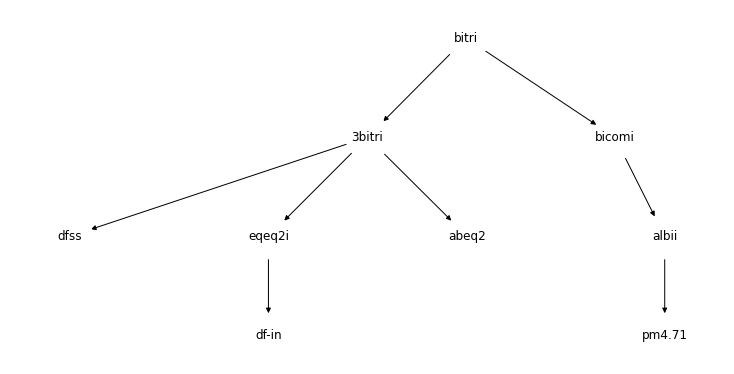

In [314]:
rep_exp_proof.print_graph()

In [288]:
root_step = exp_proof
print(root_step)
print()

exp_proof2 = expand_proof_step_ps(root_step)
exp_proof2.print_linear()

<PPStep:bitri ⊢ ( A ⊆ B ↔ ∀ x ( x ∈ A → x ∈ B ) )>

 <PPStep:impbii ⊢ ( A ⊆ B ↔ ∀ x ( x ∈ A → x ∈ B ) )>
 |  <PPStep:sylbb ⊢ ( A ⊆ B → ∀ x ( x ∈ A → x ∈ B ) )>
 |  <PPStep:sylbbr ⊢ ( ∀ x ( x ∈ A → x ∈ B ) → A ⊆ B )>
